# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer 

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

azdias.shape

(891221, 85)

In [3]:
customers = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.


In [6]:
feat_info.head(15)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [7]:
feat_info.shape

(85, 4)

In order to iterate both dataframes and get the 'missing_or_unknown' corresponding to each element selected by the iteration on the azdias dataframe, it is handy to transpose it and have the attribute as accessible by iterating on columns. 



In [8]:
feat_info_transposed= feat_info.transpose()  

feat_info_transposed.head()

,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
attribute,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
information_level,person,person,person,person,person,person,person,person,person,person,...,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,community,community,community
type,categorical,ordinal,categorical,categorical,ordinal,ordinal,ordinal,ordinal,ordinal,ordinal,...,ordinal,ordinal,ordinal,ordinal,mixed,ordinal,ordinal,ordinal,ordinal,ordinal
missing_or_unknown,"[-1,0]","[-1,0,9]","[-1,0]",[0],[-1],[-1],[-1],[-1],[-1],[-1],...,[-1],[-1],[-1],[-1],"[-1,0]",[-1],[-1],"[-1,9]","[-1,0]","[-1,9]"


In [9]:
''' In this code I am just checking and testing how to access the information I need'''


step=0
for attribute in feat_info_transposed:
    step+=1
    print(attribute)
    print(feat_info_transposed[attribute])
    #print(feat_info_transposed[attribute][3])
    if step==2:
        break
        

0
attribute                AGER_TYP
information_level          person
type                  categorical
missing_or_unknown         [-1,0]
Name: 0, dtype: object
1
attribute             ALTERSKATEGORIE_GROB
information_level                   person
type                               ordinal
missing_or_unknown                [-1,0,9]
Name: 1, dtype: object


In [10]:
''' In this code I am just checking and testing how to access the information I need'''

step=0
for attribute in feat_info_transposed:
    step+=1
    #print(attribute)
    #print(feat_info_transposed[attribute])
    print(feat_info_transposed[attribute][3])
    if step==3:
        break

[-1,0]
[-1,0,9]
[-1,0]


In [11]:
'''in order to remove brackets'''

step=0
for attribute in feat_info_transposed:
    step+=1
    #print(attribute)
    #print(feat_info_transposed[attribute])
    print(feat_info_transposed[attribute][3][1:-1])
    if step==20:
        break

-1,0
-1,0,9
-1,0
0
-1
-1
-1
-1
-1
-1
-1
0


-1,0
0
0
0
0
0


Missing values are identified in many different ways. I will try to identify and collect all these "flags" in a list and scan the azdias dataframe to check if these flags are present.

In [12]:


def remove_comma(string):
    flags=[]
    n=0
    m=0
    for character in string:
        n+=1
        m+=1
       
        if character==',':
            
            if m == 2:
                a=string[n-2:n-1]
            else:
                a=string[n-m:n-1]
            if a=='':
                pass
            else: 
                flags.append(a)
            
            m=0
        if n==len(string):
            a=string[n-m:]
            if a=='':
                pass
            else: 
                flags.append(a)

            
    return flags
                


In [13]:
remove_comma("1gyg,gy2,1,,2,3vf,7gt") #testing

['1gyg', 'gy2', '1', '2', '3vf', '7gt']

In [14]:
flags_set=set()
for attribute in feat_info_transposed:
    flag_str= feat_info_transposed[attribute][3]
    flag_str= flag_str[1:-1]
    flags= remove_comma(flag_str)
    for flag in flags:
        flags_set.add(flag)
        
        
print(flags_set)

{'XX', '9', '-1', '0', 'X'}


{'0', '-1', 'XX', 'X', '9'} This is how NaNs are labelled, plus some empty rows that suggest that None was also used.

In [15]:
flags_list=[0,-1,9,'X','XX', None]


azdias_nan=azdias.replace(to_replace=flags_list, value=np.nan)          

In [16]:
azdias_nan.head(15)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,NaN,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,NaN,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,NaN,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,NaN,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [17]:
len(azdias_nan.columns)

85

<Container object of 85 artists>

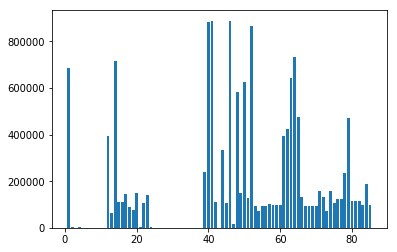

In [18]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
'''I could not get the image i wanted using .hist() because the x and y values were swapped in the plot'''
y= azdias_nan.isnull().sum().values
x= range(1,86)

plt.bar(x,y)

 Investigate patterns in the amount of missing data in each column.

There are a number of columns with more than 200 000 missing data.

In [19]:
'''This is the features with more than 200000 missing values and the corresponding labels. '''

missing_series= azdias_nan.isnull().sum()

print(len(missing_series[missing_series>200000]))
missing_series[missing_series>200000]


18


AGER_TYP            685843
GEBURTSJAHR         392318
GREEN_AVANTGARDE    715996
SHOPPER_TYP         238778
SOHO_KZ             884333
TITEL_KZ            889061
ALTER_HH            333084
ANZ_TITEL           888041
KK_KUNDENTYP        584612
WOHNDAUER_2008      624675
ANZ_HH_TITEL        867286
KBA05_ANTG1         394373
KBA05_ANTG2         425862
KBA05_ANTG3         644869
KBA05_ANTG4         733495
KBA05_BAUMAX        476524
PLZ8_ANTG3          236309
PLZ8_ANTG4          472904
dtype: int64

In [20]:
outliers_list=list(missing_series[missing_series>200000].index)

In [21]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

reduced_azdias= azdias_nan.drop(columns=outliers_list)

reduced_azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,963.0,2.0,3.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,2.0,712.0,3.0,3.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,NaN,596.0,2.0,2.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,5.0,435.0,2.0,4.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

I decided to select only columns with less than 200000 missing values.
The features with larger number of missing values are in the household-level features, micro-cell features, some personal level features (especially related to age and education) and some building level features. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

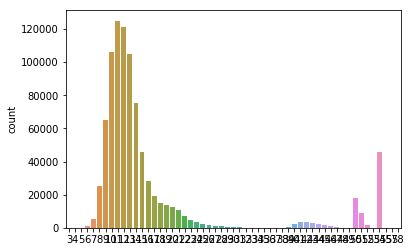

In [22]:
# How much data is missing in each row of the dataset?

y= azdias_nan.isnull().sum(axis=1).values
x= range(0,len(y))

sns.countplot(azdias_nan.isnull().sum(axis=1).values)


The plot shows that most rows have around 10 missing features; a second smaller group of rows have larger numbers of missing data. I will use 35 as threshold to separate the data. 


In [23]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.



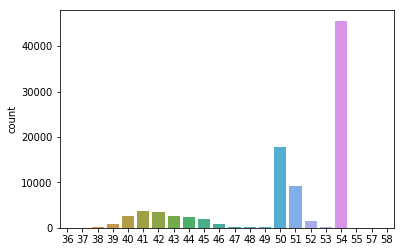

In [24]:
y_1=y[y > 35]
y_2= y[y < 35]
sns.countplot(y_1)


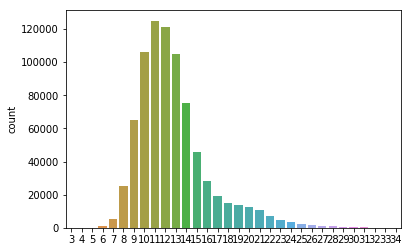

In [25]:
sns.countplot(y_2)

I will now perform the same computation on the reduced dataset from which the columns with most missing values have been dropped. 


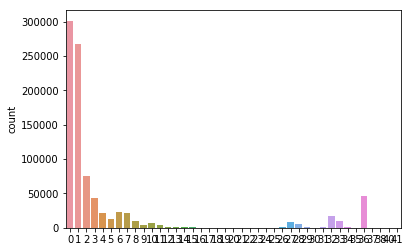

In [26]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

y_red= reduced_azdias.isnull().sum(axis=1).values


sns.countplot(y_red)

On the reduced dataframe the vast majority of rows have less than 10 features missing. 

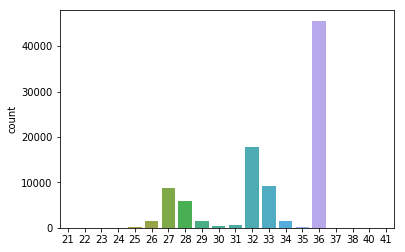

In [27]:
y_red_1=y_red[y_red > 20]
y_red_2= y_red[y_red < 35]
sns.countplot(y_red_1)

In [28]:
missing_values_df=reduced_azdias.loc[np.where(y_red == 36)]

missing_values_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Discussion 1.1.3: Assess Missing Data in Each Row

see next cell

# conclusion
it appears that there are some points with unkwown geographical information (REGIOTYP missing and related features).
The same data points were probably responsible for the spike in number of data points with 56 missing features (down to 36 when age-related and other columns were removed).

I would keep this points for general analysis and remove them for analysis in which the location is important. 

NOTE: I dropped exactly 18 columns from the first dataframe and 54-36=18 is exactly the decrease in number of features missing.
In othr words, 18 features were missing from many data points in the dataframe and 36 features are missing in a portion of the data points, probably due to way the data were collected.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [29]:
# How many features are there of each data type?
#print(feat_info.head())
#print(feat_info.head(5))

cat=np.where(feat_info['type']== 'categorical')
ordinal=np.where(feat_info['type']== 'ordinal')
mix=np.where(feat_info['type']== 'mixed')
num=np.where(feat_info['type']== 'numeric')



categorical_features=feat_info.iloc[cat]['attribute']
ordinal_features=feat_info.iloc[ordinal]['attribute']
mixed_features=feat_info.iloc[mix]['attribute']
numerical_features= feat_info.iloc[num]['attribute']

print ("categorical features: {}, ordinal features: {}, mixed features: {}, numerical features: {}".format(len(categorical_features),
                                                                                                           len(ordinal_features),
                                                                                                           len(mixed_features),
                                                                                                           len(numerical_features) ))


categorical features: 21, ordinal features: 49, mixed features: 7, numerical features: 7


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

 #### Assess categorical variables: which are binary, which are multi-level, and
 ####  which one needs to be re-encoded?

By consulting the data_dictionary it emerged that the following categorical features are binary: 
- ANREDE_KZ
- GREEN_AVANTGARDE
- SOHO_KZ
- VERS_TYP
- OST_WEST_KZ (***non-numerical***)

Some of them are above the threshold which I have used to drop features with too many missing values, I will create a new list of the categorical features which I have kept, and then use getdummies to encode all of them.


In [30]:
categorical_features

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [31]:
# Re-encode categorical variable(s) to be kept in the analysis.

categorical_features_reduced=categorical_features.drop([0,13,38,39,40,47])

reduced_encoded_azdias=pd.get_dummies(reduced_azdias, columns=categorical_features_reduced )

## reduced_encoded_azdias['OST_WEST_KZ_W'] #checking that the encoding process worked. 

#### Discussion 1.2.1: Re-Encode Categorical Features

I decided to keep all the categorical features that were below the threshold that I have used earlier to create a new dataframe with less missing values. 
In order to encode them all, I have used getdummies which allow to easily select the columns to encode. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

Mainstream values= [1,3,5,8,10,12,14]
Avantgarde values=[2,4,6,7,9,11,13,15]

In [32]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# i will create two new columns "PRAEGENDE_JUGENDJAHRE_40_60s" and "PRAEGENDE_JUGENDJAHRE_70_90s"

reduced_encoded_azdias['PRAEGENDE_JUGENDJAHRE_40_60s']=reduced_encoded_azdias["PRAEGENDE_JUGENDJAHRE"][reduced_encoded_azdias["PRAEGENDE_JUGENDJAHRE"] < 8]
reduced_encoded_azdias['PRAEGENDE_JUGENDJAHRE_70_90s']=reduced_encoded_azdias["PRAEGENDE_JUGENDJAHRE"][reduced_encoded_azdias["PRAEGENDE_JUGENDJAHRE"] >= 8]



In [33]:
# I need now to turn the two new columns into binary variables: Avantgarde(1)/Mainstream(0):

reduced_encoded_azdias['PRAEGENDE_JUGENDJAHRE_40_60s']=reduced_encoded_azdias['PRAEGENDE_JUGENDJAHRE_40_60s'].replace({1:0,2:1,3:0,4:1,5:0,6:1,7:1})
reduced_encoded_azdias['PRAEGENDE_JUGENDJAHRE_70_90s']=reduced_encoded_azdias['PRAEGENDE_JUGENDJAHRE_70_90s'].replace({8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1})

In [34]:
'''testing if it worked: '''




print(reduced_encoded_azdias['PRAEGENDE_JUGENDJAHRE_40_60s'].head(10))
print(reduced_encoded_azdias['PRAEGENDE_JUGENDJAHRE_70_90s'].head(10))

reduced_encoded_azdias=reduced_encoded_azdias.drop(columns='PRAEGENDE_JUGENDJAHRE')

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    0.0
6    NaN
7    NaN
8    NaN
9    NaN
Name: PRAEGENDE_JUGENDJAHRE_40_60s, dtype: float64
0    NaN
1    0.0
2    1.0
3    0.0
4    0.0
5    NaN
6    0.0
7    0.0
8    1.0
9    1.0
Name: PRAEGENDE_JUGENDJAHRE_70_90s, dtype: float64


# Investigate "CAMEO_INTL_2015" and engineer two new variables.

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown



### 1Y-5Y indicates and increasing wealth, and X1-X5 indicates later stages in life

In [35]:
reduced_encoded_azdias["cameo_household_wealth"]=reduced_encoded_azdias["CAMEO_INTL_2015"].replace({'11':1,'12':1,'13':1,'14':1,'15':1,
                                                                                              '21':2,'22':2,'23':2,'24':2,'25':2,
                                                                                              '31':3,'32':3,'33':3,'34':3,'35':3,
                                                                                              '41':4,'42':4,'43':4,'44':4,'45':4,
                                                                                              '51':5,'52':5,'53':5,'54':5,'55':5})

reduced_encoded_azdias["cameo_household_life_stage"]=reduced_encoded_azdias["CAMEO_INTL_2015"].replace({'11':1,'12':2,'13':3,'14':4,'15':5,
                                                                                              '21':1,'22':2,'23':3,'24':4,'25':5,
                                                                                              '31':1,'32':2,'33':3,'34':4,'35':5,
                                                                                              '41':1,'42':2,'43':3,'44':4,'45':5,
                                                                                              '51':1,'52':2,'53':3,'54':4,'55':5})



In [36]:
print(reduced_encoded_azdias["cameo_household_wealth"].head(10))
print(reduced_encoded_azdias["cameo_household_life_stage"].head(10))

reduced_encoded_azdias= reduced_encoded_azdias.drop(columns="CAMEO_INTL_2015")



0    NaN
1    5.0
2    2.0
3    1.0
4    4.0
5    5.0
6    2.0
7    1.0
8    1.0
9    1.0
Name: cameo_household_wealth, dtype: float64
0    NaN
1    1.0
2    4.0
3    2.0
4    3.0
5    4.0
6    2.0
7    4.0
8    3.0
9    5.0
Name: cameo_household_life_stage, dtype: float64


#### Discussion 1.2.2: Engineer Mixed-Type Features

I kept both mixed features. 

I ***split*** the column PRAEGENDE_JUGENDJAHRE into two columns and ***dropped the original one*** from the final DF. 
Each column represents a specific period of time in which the person was young, and each data point is either 0 or 1 according to which was the dominant movement in that person´s youth (either mainstream: 0 or avantgarde:1) .
the missing values resulting from the split of the original column are filled with NaNs, I will check later if that is a problem.

I ***duplicated*** the column CAMEO_INTL_2015 and then ***dropped the original one***.
In the new two resulting columns I assigned a value going from 1-5 for each person with the following meanings: 

column cameo_household_wealth:
- 1 wealthy
- ...
- ...
- 5 poorer

column cameo_household_life_stage:

- 1 pre-family couples and singles
- ...
- ...
- 5 Elders In Retirement

### SUMMARY:
 
 The resulting dataframe (reduced_encoded_azdias) is the product of the following steps: 
 
 
 
1. I replaced all the flags indicating missing values with NaNs. The resulting dataframe has been saved as **azdias_nan.**
2. I indentified the column with more than 200k missing values and dropped them. The resulting dataframe is: **reduced_azdias**
3. I encoded categorical features. the resulting dataframe has been saved as : **reduced_encoded_azdias**
4. I engineered and encoded mixed features and kept the same name for the dataframe. 

It is important to notice and remember that I also identified a group **rows** with unusually large numbers of NaNs, I will removed those rows later in the analysis if necessary. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [37]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [38]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [39]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    #print(df.head(3))
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    flags_list=[0,-1,9,'X','XX', None]
    
    df_nan=df.replace(to_replace=flags_list, value=np.nan)
    #print(df_nan.head(3))
    
    # remove selected columns and rows, ...
    
    '''missing_series= df_nan.isnull().sum()'''
    # I wanted to use the code above to find the columns to remove
    # But I need the same columns later in the project to be removed
    # In order to be able to apply clustering to the customers df 
    
    
    
    '''outliers_list=list(missing_series[missing_series>80000].index)'''
    # I wanted to use the code above to find the columns to remove
    # But I need the same columns later in the project to be removed
    # In order to be able to apply clustering to the customers df 
    
    
    
    #print("outliers:",outliers_list)
    
    # select, re-encode, and engineer column values.
    
    reduced_df= df_nan.drop(columns=outliers_list)
    
    reduced_encoded_df=pd.get_dummies(reduced_df, columns= categorical_features_reduced )
    
    
    reduced_encoded_df["cameo_household_wealth"]=reduced_encoded_df["CAMEO_INTL_2015"].replace({'11':1,'12':1,'13':1,'14':1,'15':1,
                                                                                              '21':2,'22':2,'23':2,'24':2,'25':2,
                                                                                              '31':3,'32':3,'33':3,'34':3,'35':3,
                                                                                              '41':4,'42':4,'43':4,'44':4,'45':4,
                                                                                              '51':5,'52':5,'53':5,'54':5,'55':5})

    reduced_encoded_df["cameo_household_life_stage"]=reduced_encoded_df["CAMEO_INTL_2015"].replace({'11':1,'12':2,'13':3,'14':4,'15':5,
                                                                                              '21':1,'22':2,'23':3,'24':4,'25':5,
                                                                                              '31':1,'32':2,'33':3,'34':4,'35':5,
                                                                                              '41':1,'42':2,'43':3,'44':4,'45':5,
                                                                                              '51':1,'52':2,'53':3,'54':4,'55':5})
    reduced_encoded_df= reduced_encoded_df.drop(columns="CAMEO_INTL_2015")
    
    reduced_encoded_df['PRAEGENDE_JUGENDJAHRE_40_60s']=reduced_encoded_df["PRAEGENDE_JUGENDJAHRE"][reduced_encoded_df["PRAEGENDE_JUGENDJAHRE"] < 8]
    reduced_encoded_df['PRAEGENDE_JUGENDJAHRE_70_90s']=reduced_encoded_df["PRAEGENDE_JUGENDJAHRE"][reduced_encoded_df["PRAEGENDE_JUGENDJAHRE"] >= 8]
    reduced_encoded_df['PRAEGENDE_JUGENDJAHRE_40_60s']=reduced_encoded_df['PRAEGENDE_JUGENDJAHRE_40_60s'].replace({1:0,2:1,3:0,4:1,5:0,6:1,7:1})
    reduced_encoded_df['PRAEGENDE_JUGENDJAHRE_70_90s']=reduced_encoded_df['PRAEGENDE_JUGENDJAHRE_70_90s'].replace({8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1})
    
    reduced_encoded_df= reduced_encoded_df.drop(columns="PRAEGENDE_JUGENDJAHRE")
    
    # Return the cleaned dataframe.
    
    return reduced_encoded_df

In [40]:
## clean_data(customers_df)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [41]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
''' To deal with the NaNs still present in the Dataframe I decided to use an immputer
and replace NaNs witht the mean along each column'''

imputer=Imputer()   #default is by column and mean!
imputed_azdias= pd.DataFrame(imputer.fit_transform(reduced_encoded_azdias))

##=reduced_encoded_azdias.drop(columns=['PRAEGENDE_JUGENDJAHRE_40_60s','PRAEGENDE_JUGENDJAHRE_70_90s'])

In [42]:
imputed_azdias.columns= reduced_encoded_azdias.columns

In [43]:
imputed_azdias.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_40_60s,PRAEGENDE_JUGENDJAHRE_70_90s,cameo_household_wealth,cameo_household_life_stage
0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,2.190129,15.000000,4.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.261206,0.158909,3.262098,2.873033
1,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.000000,21.000000,6.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.261206,0.000000,5.000000,1.000000
2,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.000000,3.000000,1.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.261206,1.000000,2.000000,4.000000
3,4.0,4.0,2.0,5.0,2.0,1.0,2.0,2.000000,16.454901,4.69045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.261206,0.000000,1.000000,2.000000
4,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.000000,32.000000,10.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.261206,0.000000,4.000000,3.000000


In [44]:
imputed_azdias.PRAEGENDE_JUGENDJAHRE_70_90s.head(5)

0    0.158909
1    0.000000
2    1.000000
3    0.000000
4    0.000000
Name: PRAEGENDE_JUGENDJAHRE_70_90s, dtype: float64

In [45]:
reduced_encoded_azdias.PRAEGENDE_JUGENDJAHRE_70_90s.head(5)

0    NaN
1    0.0
2    1.0
3    0.0
4    0.0
Name: PRAEGENDE_JUGENDJAHRE_70_90s, dtype: float64

In [46]:
imputed_azdias.isnull().mean(axis=0).sort_values(ascending=False).head(10)  #TOP n COLUMNS FOR % OF NANs

cameo_household_life_stage    0.0
GFK_URLAUBERTYP_3.0           0.0
GFK_URLAUBERTYP_1.0           0.0
FINANZTYP_6                   0.0
FINANZTYP_5                   0.0
FINANZTYP_4                   0.0
FINANZTYP_3                   0.0
FINANZTYP_2                   0.0
FINANZTYP_1                   0.0
CJT_GESAMTTYP_6.0             0.0
dtype: float64

In [47]:
imputed_azdias.isnull().mean(axis=1).sort_values(ascending=False).head(5) #TOP % OF MISSING VALUES IN THE ROWS

891220    0.0
297067    0.0
297078    0.0
297077    0.0
297076    0.0
dtype: float64

#### imputation seems to have worked as expected.

In [48]:
# Apply feature scaling to the general population demographics data.

scaler= StandardScaler()
scaled_azdias=pd.DataFrame(scaler.fit_transform(imputed_azdias))



In [49]:
scaled_azdias.columns= imputed_azdias.columns
scaled_azdias.head(5)

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_40_60s,PRAEGENDE_JUGENDJAHRE_70_90s,cameo_household_wealth,cameo_household_life_stage
0,-0.750972,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,0.000000,-1.263196e-01,-2.026690e-01,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,0.0,-9.854144e-17,3.216984e-16,6.346104e-16
1,-1.742724,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,1.146266,3.946213e-01,3.843946e-01,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,0.0,-5.641781e-01,1.258937e+00,-1.338297e+00
2,0.240781,-1.570358,0.804890,-1.816084,-0.675554,0.084637,1.422415,1.146266,-1.168201e+00,-1.083264e+00,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,0.0,2.986152e+00,-9.142640e-01,8.052265e-01
3,1.232533,0.700556,-0.560532,1.209329,-0.675554,-1.260597,-0.794475,-0.269102,-3.084590e-16,-2.607086e-16,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,0.0,-5.641781e-01,-1.638664e+00,-6.237891e-01
4,0.240781,0.700556,0.122179,0.452976,-1.329319,0.084637,-0.794475,1.146266,1.349680e+00,1.558522e+00,...,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,0.0,-5.641781e-01,5.345367e-01,9.071870e-02


### sanity check!

In [50]:
print(imputed_azdias.ALTERSKATEGORIE_GROB.mean())
print(imputed_azdias.ALTERSKATEGORIE_GROB.std())

mean=imputed_azdias.ALTERSKATEGORIE_GROB.mean()
std=imputed_azdias.ALTERSKATEGORIE_GROB.std()

((imputed_azdias.ALTERSKATEGORIE_GROB-mean)/std).head(10)

2.75721683139
1.00831687843


0   -0.750971
1   -1.742723
2    0.240781
3    1.232532
4    0.240781
5   -1.742723
6   -0.750971
7   -1.742723
8    0.240781
9    0.240781
Name: ALTERSKATEGORIE_GROB, dtype: float64

In [51]:
def impute_scale(df):
    
    imputer=Imputer()   #default is by column and mean!
    imputed_df= pd.DataFrame(imputer.fit_transform(df))
    scaler= StandardScaler()
    scaled_df=pd.DataFrame(scaler.fit_transform(imputed_df))
    scaled_df.columns=df.columns
    return scaled_df

### Discussion 2.1: Apply Feature Scaling

I decided to impute the whole DataFrame with the mean value for each column, I then applied stadard scaler.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [52]:
# Apply PCA to the data.

pca= PCA()
pca.fit(imputed_azdias)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

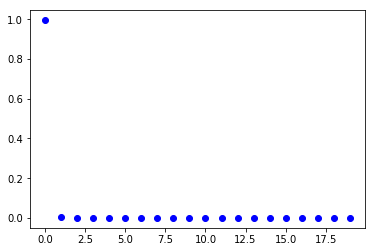

In [53]:
# Investigate the variance accounted for by each principal component.
#print(pca.explained_variance_ratio_)
#print(pca.explained_variance_ratio_)

 

n=0
m=20
plt.plot(range(len(pca.explained_variance_ratio_[n:m])),pca.explained_variance_ratio_[n:m], 'bo')

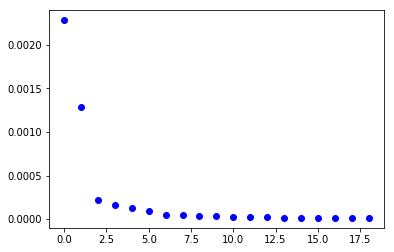

In [54]:
n=1
m=20
plt.plot(range(len(pca.explained_variance_ratio_[n:m])),pca.explained_variance_ratio_[n:m], 'bo')

In [55]:
'''I ha changed the numbers to check which component is responsible for how much'''

print(pca.explained_variance_ratio_[:5])
print(pca.explained_variance_ratio_[:5].sum())

[  9.95227720e-01   2.28207470e-03   1.28982017e-03   2.14576846e-04
   1.67187439e-04]
0.999181379133


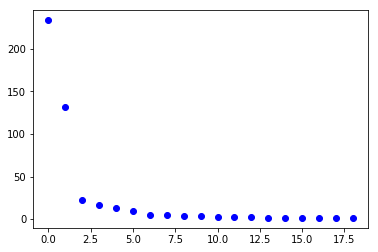

In [56]:
n=1
m=20
plt.plot(range(len(pca.explained_variance_[n:m])),pca.explained_variance_[n:m], 'bo')

Variance explained by ***n*** principal components:

- ***n*** =1; variance explained= 0.995%
- ***n*** =5; variance explained= 0.9991%
- ***n*** =10; variance explained=0.9995%

- The second principal component seems to explain only 0.0023% of the variance in the dataframe. 
- The third principal component seems to explain only 0.0013% of the variance in the dataframe. 

Since PCA suggests that one main component is able to explain most of the variance in the data, I will apply PCA setting 2 as n_components value and I will then analyse each component of the main components 

In [57]:
pca_comp= pd.DataFrame(pca.components_, columns=imputed_azdias.columns)
pca_comp.iloc[0].sort_values( ascending=False).head()

KBA13_ANZAHL_PKW       0.999978
LP_LEBENSPHASE_FEIN    0.002811
PLZ8_GBZ               0.002329
PLZ8_HHZ               0.002019
INNENSTADT             0.001126
Name: 0, dtype: float64

### 8.1. KBA13_ANZAHL_PKW
Number of cars in the PLZ8 region

In [58]:
pca_comp.iloc[1].sort_values( ascending=False).head()

ANZ_HAUSHALTE_AKTIV       0.919575
HH_EINKOMMEN_SCORE        0.038490
cameo_household_wealth    0.033955
EWDICHTE                  0.032467
PLZ8_BAUMAX               0.032405
Name: 1, dtype: float64

### 3.1. ANZ_HAUSHALTE_AKTIV
Number of households in the building
- missing values encoded by 0

In [59]:
# Re-apply PCA to the data while selecting for number of components to retain.

imputed_azdias=imputed_azdias.drop(columns="GEBAEUDETYP_5.0") # I had to drop this column for the last part of the project


In [60]:
# Even if fewer components are able to explain most of the variance, I decided to have more of them because of the last part of the project


pca= PCA(n_components=10)
pca_azdias= pca.fit_transform(imputed_azdias)


In [61]:
#pca_comp= pd.DataFrame(pca.components_, columns=imputed_azdias.columns)

pca_comp= pd.DataFrame(pca.components_,columns=imputed_azdias.columns)


pca_comp.head()


,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_40_60s,PRAEGENDE_JUGENDJAHRE_70_90s,cameo_household_wealth,cameo_household_life_stage
0,0.000043,0.000345,-0.000137,0.000214,0.000050,0.000200,-0.000505,-0.000005,0.002811,0.000737,...,-0.000014,-0.000007,-0.000042,-0.000044,-0.000040,-0.000001,0.000029,0.000051,-0.000843,0.000434
1,-0.003183,-0.031535,0.010730,-0.004626,-0.000168,-0.002255,0.031514,0.001472,-0.353329,-0.098947,...,0.000652,0.000725,0.001446,0.001576,0.001392,0.001161,-0.001820,-0.002651,0.033955,-0.016218
2,0.007624,0.025374,-0.015170,0.012946,-0.006802,-0.011771,-0.019458,-0.003052,0.880929,0.250432,...,-0.000225,0.000220,-0.000543,-0.000449,-0.000643,0.000489,0.001483,0.002814,-0.015811,0.011032
3,-0.154016,-0.070471,0.197954,-0.169025,0.133803,0.165360,-0.046505,0.019696,0.032741,-0.018726,...,-0.001767,0.001333,0.001855,0.001811,0.000874,-0.001527,0.000898,0.003121,0.014122,-0.041059
4,0.112134,0.166925,-0.189898,0.143364,-0.230638,-0.185085,-0.042435,-0.019507,-0.040393,0.007803,...,0.001311,-0.001035,-0.000359,0.000247,-0.000394,0.000732,0.001302,0.001923,-0.025490,0.032033


In [62]:
pca_comp.iloc[0].sort_values( ascending=False).head()

KBA13_ANZAHL_PKW       0.999978
LP_LEBENSPHASE_FEIN    0.002811
PLZ8_GBZ               0.002329
PLZ8_HHZ               0.002019
INNENSTADT             0.001126
Name: 0, dtype: float64

 Number of cars

In [63]:
pca_comp.iloc[1].sort_values( ascending=False).head(5)

ANZ_HAUSHALTE_AKTIV       0.919575
HH_EINKOMMEN_SCORE        0.038490
cameo_household_wealth    0.033955
EWDICHTE                  0.032467
PLZ8_BAUMAX               0.032405
Name: 1, dtype: float64

Density of population

In [64]:
pca_comp.iloc[2].sort_values( ascending=False).head(5)

LP_LEBENSPHASE_FEIN    0.880929
ANZ_HAUSHALTE_AKTIV    0.379133
LP_LEBENSPHASE_GROB    0.250432
ANZ_PERSONEN           0.059598
ONLINE_AFFINITAET      0.030550
Name: 2, dtype: float64

 Life stage

I want to apply PCA on a dataframe in which I have removed all the datapoints with missing values without imputing those values. 
This is to check whether the result is affected by the imputation. 
I will also try to remove the other columns with many missing values and apply PCA again. 

In [65]:

'''Additional steps/cells not required, uncomment to exectue.'''
#no_na_azdias=reduced_encoded_azdias.drop(columns=["PRAEGENDE_JUGENDJAHRE_40_60s", "PRAEGENDE_JUGENDJAHRE_70_90s"]).dropna()
#pca_no_na= PCA()
#pca_no_na.fit(no_na_azdias)



'Additional steps/cells not required, uncomment to exectue.'

In [66]:
#pca_comp_no_na= pd.DataFrame(pca_no_na.components_, columns=no_na_azdias.columns)
#pca_comp_no_na.iloc[0].sort_values( ascending=False).head()

In [67]:
#pca_comp_no_na= pd.DataFrame(pca_no_na.components_, columns=no_na_azdias.columns)
#pca_comp_no_na.iloc[1].sort_values( ascending=False).head()

In [68]:
#pca_comp_no_na= pd.DataFrame(pca_no_na.components_, columns=no_na_azdias.columns)
#pca_comp_no_na.iloc[2].sort_values( ascending=False).head()

In [69]:
'''Additional step not requested as part of the project'''

#new_df= reduced_encoded_azdias.drop(columns=reduced_encoded_azdias.isna().sum().sort_values()[-15:].index )##15 columns with more missing values!

#new_df=impute_scale(new_df)

#new_pca=PCA()
#new_pca.fit(new_df)





'Additional step not requested as part of the project'

In [70]:
##  pca_explain(new_pca, 3, new_df)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [71]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

''' 

The .components_ attribute of an sklearn PCA object 
returns a list of the main components.
Each one of them is expressed as a vector or linear combination of the original features.
The list is ordered according to the amount of variance explained by each of these vectors.

Also, the more important one of the features is for a certain main component, 
the more that component will be on roughly the same "direction" of that feature. 
In other words, the weight or the value in the linear combination will be higher.

This means that for main component 1, the feature associated with the highest weight can be used to
interpret that main component, and the variance explained by that main component.

The following function will print the n-1 components of the PCA object and will identify the features
more important in each of the component. it will also print the % of exaplained variance associated
with that main component.


'''

def pca_explain(pca, n, df):

    pca_comp= pd.DataFrame(pca.components_,columns=imputed_azdias.columns)
    for n in range(n):
      
        print("\n\n\nExaplained variance by component {}: {:.3}%".format(n+1, pca.explained_variance_ratio_[n]))
        print("Main features of main component {}:\n{}".format(n+1, pca_comp.iloc[n].sort_values( ascending=False).head(5)))
        
        print("\n\n\n Exaplained variance by component {}: {:.3}%".format(n+1, pca.explained_variance_ratio_[n]))
        print("Main negative features of main component {}:\n{}".format(n+1, pca_comp.iloc[n].sort_values( ascending=True).head(5)))
        
pca_explain(pca, 3, imputed_azdias)




Exaplained variance by component 1: 0.995%
Main features of main component 1:
KBA13_ANZAHL_PKW       0.999978
LP_LEBENSPHASE_FEIN    0.002811
PLZ8_GBZ               0.002329
PLZ8_HHZ               0.002019
INNENSTADT             0.001126
Name: 0, dtype: float64



 Exaplained variance by component 1: 0.995%
Main negative features of main component 1:
ANZ_HAUSHALTE_AKTIV      -0.003924
PLZ8_BAUMAX              -0.001247
EWDICHTE                 -0.001071
RELAT_AB                 -0.001028
cameo_household_wealth   -0.000843
Name: 0, dtype: float64



Exaplained variance by component 2: 0.00228%
Main features of main component 2:
ANZ_HAUSHALTE_AKTIV       0.919575
HH_EINKOMMEN_SCORE        0.038490
cameo_household_wealth    0.033955
EWDICHTE                  0.032467
PLZ8_BAUMAX               0.032405
Name: 1, dtype: float64



 Exaplained variance by component 2: 0.00228%
Main negative features of main component 2:
LP_LEBENSPHASE_FEIN   -0.353329
LP_LEBENSPHASE_GROB   -0.098947
MOBI_R

In [72]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

'''see previous cell'''

'see previous cell'

In [73]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

'''see two cells above'''

'see two cells above'

### Discussion 2.3: Interpret Principal Components


The ***first principal components*** is in the "direction" (in the vector space of the original 180+ features) of ***KBA13_ANZAHL_PKW***
which is the **number of cars owned**. 
Most of the original features are related directly or indirectly with wealth, and the number of owned cars seems to be strongly correlated to the other features and therefore it weights a lot in the components which exaplains most of the variance. 
Considering that most features are indicators of wealth with increasing numbers corresponding to increasing wealth, I am not surprised that one component can explain most of the variance (all the other component are orthogonal to it).

The ***second principal component*** has **ANZ_HAUSHALTE_AKTIV** as main feature, which is the **number of households** in a building. This main component is able to exaplain a small amount of variance in the data and it is inversely correlated to LP_LEBENSPHASE_FEIN, which is the life stage/wealth.
It makes sense that the higher ANZ_HAUSHALTE_AKTIV, the lower I expect LP_LEBENSPHASE_FEIN to be. Namely, later stages in life and increased wealth are linked to a greater ability to afford to live in a less crowded area/building. 

Finally the ***third principal components*** simply correlates **life stage** and children with likelihood of **children linving in a household**. Probably wealthy families have fewer children, as well as older couple are much less likely to have children.

I repeaded the PCA analysis removing all the datapoints (rows) with missing data. I did not find any major difference. However, when I removed several features (columns with higher number of missing data) i did find a different results.
In this last case there was no main component able to exaplain the same amount of variance and the main components explain variance in terms of these opposites:

- (+)Ivestors and savers / (-)Low financial interest. 
- (+)Investor / (-)Homeowner. 

    This is interesting because people with knowledge of economy/finance always recommend investing as a better way to gain
    wealth in comparison with homeownership.
    
    
- (+)Dreamful personality / (-)combative personality 

It makes sense that these main components can explain other wealth-related features, but when using most of the datapoints as I did in the previous discussion, one clear indicator of wealth emerged: the number of cars possessed, on the other hand, these main components are merely able to explain roughly 5% of variance each. 



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [74]:


pca_azdias=pd.DataFrame(pca_azdias)
pca_azdias.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.004223,0.648657,-1.615473,0.729361,-4.656494,0.707385,-0.316705,3.044235,-4.521634,-0.411934
1,343.241625,2.876677,4.486949,3.702671,-5.779234,-0.963396,-2.637070,-4.388732,1.652491,2.419861
2,92.198729,7.187892,-12.345754,-4.085730,-2.743096,0.058945,-0.598679,2.375403,4.200494,-0.788037
3,-23.708962,-7.674156,-2.258511,-4.012642,2.293715,5.231125,1.538220,-0.641703,2.155120,-1.680174
4,-184.695346,-11.792356,13.691605,1.893394,4.734912,-5.738126,1.574887,-0.875315,1.487103,-3.137315


In [75]:
'''I am going to use a subset of the original dataframe to find the best number of clusters'''

toy_df=pca_azdias.iloc[100000:200000]
toy_df.shape

(100000, 10)

[10, 13, 16, 19, 22, 25, 28, 31, 34]
[2238348149.3055615, 1479697515.0685494, 1092473211.3939745, 900837116.67163396, 763254727.94345522, 672968448.56330228, 602253530.07125235, 539575769.12086284, 493097728.17883599]


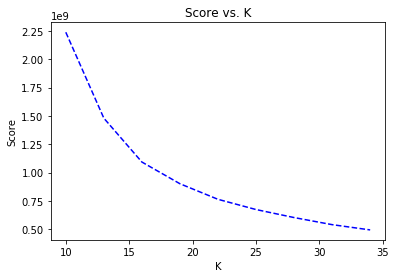

In [76]:
score_list, clusters = [], []
for k in range(10,36,3):
    kmeans= KMeans(k)
    model=kmeans.fit(pca_azdias)
    score=abs(model.score(pca_azdias))
    score_list.append(score)
    clusters.append(k)
print(clusters)   
print(score_list)    
plt.plot(clusters, score_list, linestyle='--', color='b')
plt.xlabel('K');
plt.ylabel('Score');
plt.title('Score vs. K');

I am going to use 22 clusters 

In [77]:


# Over a number of different cluster counts...
kmeans= KMeans(n_clusters=22) 

# run k-means clustering on the data and...
     
model= kmeans.fit(pca_azdias)
 
# compute the average within-cluster distances.
    
labels= model.predict(pca_azdias)    



In [78]:
avg_distance= abs(model.score(pca_azdias))/pca_azdias.shape[0]
print(avg_distance)

858.41999789


In [79]:
pca_azdias["Cluster"]=labels

cluster_size=[]
for n in range(0,22):
    points= pca_azdias[pca_azdias["Cluster"]== n].shape[0]
    cluster_size.append(points)

#cluster_size

In [80]:
m=0
cluster_percentage=[]
for cluster in cluster_size: 
    m+=1
    cluster_percentage.append(cluster/(pca_azdias.shape[0]/100))
    print("cluster {} is:{:.3}% of the population".format(m,cluster/(pca_azdias.shape[0]/100)))

cluster 1 is:7.49% of the population
cluster 2 is:2.3% of the population
cluster 3 is:5.7% of the population
cluster 4 is:0.719% of the population
cluster 5 is:5.88% of the population
cluster 6 is:4.37% of the population
cluster 7 is:1.32% of the population
cluster 8 is:3.75% of the population
cluster 9 is:7.03% of the population
cluster 10 is:6.93% of the population
cluster 11 is:2.41% of the population
cluster 12 is:18.3% of the population
cluster 13 is:0.103% of the population
cluster 14 is:5.01% of the population
cluster 15 is:0.37% of the population
cluster 16 is:2.89% of the population
cluster 17 is:1.17% of the population
cluster 18 is:1.62% of the population
cluster 19 is:3.22% of the population
cluster 20 is:4.42% of the population
cluster 21 is:7.5% of the population
cluster 22 is:7.5% of the population


In [81]:
cluster_percentage=np.array(cluster_percentage)
cluster_percentage

array([  7.48781728,   2.30302024,   5.70240154,   0.7194624 ,
         5.88484787,   4.37209177,   1.31527421,   3.74856517,
         7.02743764,   6.92600376,   2.40512735,  18.29995029,
         0.10300475,   5.01121495,   0.37016632,   2.89142648,
         1.17064118,   1.6186782 ,   3.22265746,   4.42191106,
         7.5002721 ,   7.49802799])

In [82]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.


In [83]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.



### Discussion 3.1: Apply Clustering to General Population

I decided to segment the population into 22 clusters, although I could not find a clear "elbow shape" to find the best number of clusters to greatly reduce the average distance, 22 seems to be a good compromise between minising the distance and having a code that exectues quickly enough. 
I have used a reduced, "toy" dataframe to find that number because using the full dataframe turned out to be too much in terms of computation (it would require several hours) 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [84]:
# Load in the customer demographics data.
customers= pd.read_csv( 'Udacity_CUSTOMERS_Subset.csv', delimiter=';')


In [85]:
#to find a missing column and fix


'''for m in range(118,182):
    print(imputed_azdias.columns[m])
    print("-{}".format(customers.columns[m]))'''



'for m in range(118,182):\n    print(imputed_azdias.columns[m])\n    print("-{}".format(customers.columns[m]))'

In [86]:
customers= clean_data(customers)
customers= impute_scale(customers)



In [87]:
'''for m in range(181):
    print(customers.columns[m])
    print("-",imputed_azdias.columns[m])'''

'for m in range(181):\n    print(customers.columns[m])\n    print("-",imputed_azdias.columns[m])'

In [88]:
customers= pca.transform(customers)

In [89]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
model.fit(customers)
customers_labels= model.predict(customers)
customers=pd.DataFrame(customers)
customers.head()

,0,1,2,3,4,5,6,7,8,9
0,-618.727726,52.228076,-29.735498,-111.811390,36.511951,-947.515886,-1675.004569,225.944556,130.201420,-71.124217
1,-620.575056,52.495630,-29.121479,-111.138021,34.421174,-948.805953,-1673.851762,224.657102,130.454529,-72.016141
2,-621.396339,53.224896,-30.997685,-115.913584,31.042408,-951.058257,-1673.259161,223.440432,129.302600,-71.918446
3,-620.263570,52.222102,-29.087605,-110.649578,34.704214,-946.000936,-1676.406181,222.921372,131.971006,-72.047844
4,-621.113645,52.804393,-28.415230,-108.794176,30.861389,-951.285018,-1673.667472,221.078167,131.118237,-71.959536


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [90]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

customers["Cluster"]=customers_labels

customer_cluster_size=[]
for n in range(0,22):
    points= customers[customers["Cluster"]== n].shape[0]
    customer_cluster_size.append(points)

m=0
customer_cluster_percentage=[]
for cluster in customer_cluster_size: 
    m+=1
    customer_cluster_percentage.append(cluster/(customers.shape[0]/100))
    print("cluster {} is:{:.6}% of the population".format(m,cluster/(customers.shape[0]/100)))


cluster 1 is:3.17137% of the population
cluster 2 is:24.424% of the population
cluster 3 is:3.59714% of the population
cluster 4 is:5.86219% of the population
cluster 5 is:5.24597% of the population
cluster 6 is:4.9496% of the population
cluster 7 is:2.53063% of the population
cluster 8 is:6.20969% of the population
cluster 9 is:3.2272% of the population
cluster 10 is:4.73201% of the population
cluster 11 is:4.40695% of the population
cluster 12 is:1.37697% of the population
cluster 13 is:1.93997% of the population
cluster 14 is:3.23138% of the population
cluster 15 is:5.13013% of the population
cluster 16 is:4.78419% of the population
cluster 17 is:0.262977% of the population
cluster 18 is:4.80089% of the population
cluster 19 is:3.27625% of the population
cluster 20 is:2.97831% of the population
cluster 21 is:2.46541% of the population
cluster 22 is:1.3968% of the population


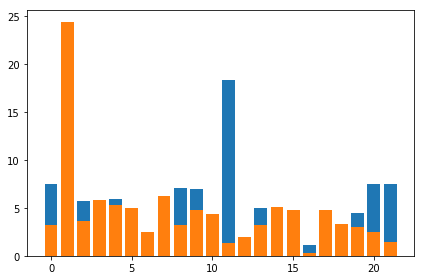

In [91]:
fig, ax = plt.subplots()
    
a=ax.bar(range(len(cluster_percentage)), cluster_percentage)
b=ax.bar(range(len(customer_cluster_percentage)), customer_cluster_percentage)

fig.tight_layout()
plt.show()

In [131]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

over_repr_group= customers[customers["Cluster"]==2]
largest_cluster= pca_azdias[pca_azdias["Cluster"]==12]

over_repr_group.shape

(6894, 11)

In [132]:
customers_original= pd.read_csv( 'Udacity_CUSTOMERS_Subset.csv', delimiter=';')

over_repr_group= customers_original.iloc[over_repr_group.index]
largest_cluster= imputed_azdias.iloc[largest_cluster.index]
print(customers_original.shape)
over_repr_group.shape

(191652, 85)


(6894, 85)

In [141]:
largest_cluster.mean().sort_values()[100:110]  # This is to check scores on each feature

LP_STATUS_FEIN_10.0     0.175381
LP_FAMILIE_FEIN_10.0    0.184096
LP_STATUS_FEIN_4.0      0.190632
CAMEO_DEUG_2015_4       0.197168
CJT_GESAMTTYP_2.0       0.197168
FINANZTYP_1             0.209150
CJT_GESAMTTYP_3.0       0.209150
CAMEO_DEUG_2015_3       0.211329
CAMEO_DEUG_2015_2       0.211329
ZABEOTYP_1              0.222222
dtype: float64

In [151]:
over_repr_group.mean().sort_values()["MOBI_REGIO"]

3.8737080103359172

What kinds of people are part of a cluster that is underrepresented in the
customer data compared to the general population?

These are the features of the underrepresented group: 

- financially incospicuous (finanz-typ 0.43)
- living in small communities (5000-20000 inhabitants)
- average to low score for the "investor" feature and average to high score for "money-saver" 
- household life stage closer to "mature couples" stage
- 42 years old average
- German nationality
- homeowner couples of higher age
- very poor neighborhood
- average affinity for most personality traits, lowest affinity for "rational"
- average of 4 other households in the building 
- low score for movement patterns 
- high to average purchasing power 

Some of these scores are the opposite of those in the overrapresented group in tthe customers data.
Some of the score in features in the overrapresented group: 

- more than half part of the green avantgarde
- very high score in "money-saver" and "investor"
- single
- women 
- high/very high purchasing power 
- German nationality 
- 42 years old (slightly less than the other cluster) 
- living in medium sized communities (50000-100000 inhabitants)

### Discussion 3.3: Compare Customer Data to Demographics Data


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.